# notebook.ipynb

Este cuaderno consiste en el análisis de una base de datos compuesta por frases, mediante métodos enfocados explotación semántica mediante técnicas estadísticas, de ML y análisis frecuencial, principalmente.

Cabe mencionar que a lo largo de este cuaderno se presentan conceptos y técnicas básicas y con fines explicativos, a veces de manera muy distinta a como debería realizarse en un escenario o una aplicación real. Se verán comentados posibles pasos futuros e implementaciones de técnicas más complejas y adecuadas donde corresponda.

**Índice**

- [Instalación](#instalacion)
- [Declaración de autoría](#declaracion-de-autoria)
- [Dataset](#dataset)
- [Compresion de las sentencias](#compresion-de-las-sentencias)
- [Reduccion de la dimensionalidad](#reduccion-de-la-dimensionalidad)
  - [Enfoque alternativo: partir de matriz TF-IDF](#enfoque-alternativo-partir-de-matriz-tf-idf)
- [Analisis estadistico exploratorio del dataset](#analisis-estadistico-exploratorio-del-dataset)
  - [Longitud de frase](#longitud-de-frase)
  - [Histograma de longitudes](#histograma-de-longitudes)
  - [Analisis de frecuencia de palabras](#analisis-de-frecuencia-de-palabras)
  - [Nube de palabras](#nube-de-palabras)
  - [Analisis de patrones sintacticos](#analisis-de-patrones-sintacticos)
- [Preprocesamiento](#preprocesamiento)
- [Analisis semantico](#analisis-semantico)
- [Reduccion de dimensionalidad](#reduccion-de-dimensionalidad)
- [Clustering](#clustering)
- [Busqueda semantica](#busqueda-semantica)
- [Aplicación a resumen de texto](#aplicacion-a-resumen-de-texto)
- [Conclusiones](#conclusiones)
- [Referencias](#referencias)

## Instalación

El cuaderno está desarrollado dentro de Visual Studio Code (VS Code) pero es portable a la plataforma Jupyter Notebook (.ipynb, que es un formato conformado por puro JSON). Se usa Python 3.12.3 y pip 24.0. El entorno de desarrollo del autor es WSL 2 (dentro de Windows 10 Pro) y todos los paquetes se instalan en un entorno virtual `venv`:

```bash
cd /opt/cambrian_notebook
python3 -m venv .venv
source .venv/bin/activate
pip install notebook ipykernel
code .
```

Es necesario instalar varios paquetes y dependencias para ejecutar todo el notebook, pero `pip freeze` proporciona todas las liberías del entorno virtual (aunque no se usen en el código). Así que para generar el archivo `requirements.txt` se usa `pipreqs . --scan-notebooks --force`. Para instalarlas:

```bash
pip install -r requirements.txt
```

## Declaración de autoría

A lo largo de este notebook se presentarán ideas, teoremas y resoluciones que son tanto propias del autor como inspiradas en referencias web, bibligráficas o chatbots (e.g. ChatGPT). 

- Las **referencias web y bibliográficas** se citan debidamente en línea con el texto, documentadas en el apartado [Referencias](#referencias). El contenido ideado y desarrollado por el autor se representa en un font normal, de <ins>este color</ins>.

- Las secciones que son **adaptaciones de consultas a chatbots** (con modificaciones o extensiones casi totales) se redactan en color <span style="color:green">verde</span>. 

- Las secciones formadas por **texto y código extraído directamente desde chatbots** (con modificaciones parciales) se indican en color <span style="color:red">rojo</span>.

## Dataset 

Se utiliza el archivo `sentences.json`. A primera vista, por la lectura aleatoria de varios objetos del JSON, parece un listado de frases de connotación objetiva pero que se centran en resaltas cualidades de alto nivel de abstracción de los sustantivos (sujetos) alrededor de los que están centrados. Su finalidad puede ser la de entrenar modelos de lenguaje destinados a la descripción detallada y abstracta de objetos de un escenario real, e.g. para complementar aplicaciones de segmentación semántica en tiempo real, como CLIP-SAM [1], LSeg [2] u otros que utilicen ViTs (Vision Transformers). También podría usarse para enriquecer la comprensión de modelos de lenguaje destinados a establecer relaciones en contextos descriptivos variados, ya que las frases abarcan muchos significados, a muchos niveles de abstracción, en muy pocas palabras (e.g. en el objeto *The octopus had remarkable intelligence, solving puzzles easily* se contemplan cualidades y capacidades físicas, datos objetivos y reales, ironías reforzadas, causalidades y efectos, etc.). Usos más típicos son el entrenamiento de modelos de *embedding* o *rerankers* [7].

## Compresión de las sentencias

El dataset, tal como está dado, pesa aproximadamente 7211 bytes (8 KB en disco) (según el explorador de archivos del SO). Concretamente, considerando que un caracter ASCII se almacena y transmite en paquetes de 8 bits (1 byte) (aunque sus caracteres quepan en solo 7 bits) [3] y contando todos los caracteres en el archivo de texto (sumándoles las comas, comillas y corchetes), se estima manualmente el peso del archivo con <span style="color:red">el siguiente script, por curiosidad</span>:

In [1]:
ruta_archivo = './sentences.json'

# Leer el archivo JSON como texto
with open(ruta_archivo, 'r', encoding='utf-8') as f:
    contenido = f.read()

# Contar caracteres (tamaño en bytes si es ASCII/UTF-8 simple)
num_caracteres = len(contenido)

print(f"El archivo tiene {num_caracteres} caracteres, lo que equivale a {num_caracteres} bytes ({num_caracteres * 8} bits).")

El archivo tiene 7211 caracteres, lo que equivale a 7211 bytes (57688 bits).


Podemos diseñar un algoritmo naif de compresión sin pérdida, que considere repeticiones consecutivas de letras en cada palabra para tratar de reducir el tamaño del dataset. E.g. la palabra "aaaabbbcc" se convierte en "4a3b2c", que "pesa" 3 caracteres menos que la versión original. Esto se denomina Run-Length Encoding (RLE), y <span style="color:red">una implementación básica se da en el siguiente script</span>:

In [42]:
import json
import re

def rle_compress_word(word):
    """Compresor RLE para palabras (solo letras consecutivas)"""
    if not word:
        return word
        
    compressed = []     # Palabra comprimido
    prev_char = word[0] # Buscar repeticiones inmediatamente anteriores
    count = 1           # Número de repeticiones inmediatamente anteriores
    
    for char in word[1:]: # Empezar por la segunda letra de la palabra
        if char == prev_char and char.isalpha(): # Si es igual a la anterior, aumentar contador
            count += 1
        else: 
            # Si es distinta a la anterior, almacenar el anterior resultado, usando guarismo solo si hubo repetición
            compressed.append(f"{count}{prev_char}" if count > 1 else prev_char)
            count = 1
            prev_char = char
    
    # Almacenar resultado del último carácter
    compressed.append(f"{count}{prev_char}" if count > 1 else prev_char)
    
    return ''.join(compressed)

def compress_sentence(sentence):
    """Aplica RLE a cada palabra manteniendo puntuación"""
    tokens = re.findall(r"\w+|\s+|[^\w\s]", sentence)
    return ''.join([rle_compress_word(token) if token.strip() else token for token in tokens])

def process_json_file(input_path, output_path):
    """Procesa un archivo JSON completo"""
    with open(input_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Comprime todas las frases
    compressed_data = [compress_sentence(sentence) for sentence in data]
    
    # Guarda el resultado en una sola línea
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(compressed_data, f, ensure_ascii=False) # sin indentación = sin saltos de línea
    
    print(f"Compresión completada. Resultado guardado en {output_path}")

input_json = 'sentences.json'      
output_json = 'sentences_rle.json'
process_json_file(input_json, output_json)

Compresión completada. Resultado guardado en sentences_rle.json


In [43]:
ruta_archivo = './sentences_rle.json'
with open(ruta_archivo, 'r', encoding='utf-8') as f:
    contenido = f.read()
num_caracteres = len(contenido)
print(f"El archivo tiene {num_caracteres} caracteres, lo que equivale a {num_caracteres} bytes ({num_caracteres * 8} bits).")

El archivo tiene 7211 caracteres, lo que equivale a 7211 bytes (57688 bits).


Tampoco tiene mayor sentido esta compresión básica con frases de un lenguaje humano, pues es difícil que haya palabras con más de 2 caracteres iguales consecutivos, por lo que el archivo comprimido pesa lo mismo. Un enfoque más inteligente sería comprimir combinaciones palabras (e.g. "in a", "from the", "it is"...), generando un diccionario de claves para decodificar el mensaje comprimido. Pero solo se quería mencionar esta posibilidad como idea abierta.

Eso sí, podríamos preguntarnos si esta "reformulación" de los objetos (o una similar) repercutiría en el entrenamiento de un modelo de lenguaje. Intuitivamente, parece lógico pensar que la "acortación" de cadenas extensas en representaciones comprimidas puede potenciar (o, como mínimo, optimizar) la búsqueda de patrones repetitivos en el dataset. Por otra parte, se introducen símbolos no léxicos, no presentes en el dataset original (agregando una capa de preprocesamiento adicional necesaria de cara a la inferencia) y, además, la reestructuración morfológica o fonética de las palabras puede modificar la interpretación del modelo sobre ellas, aunque también se puede pensar que el significado interno nunca se verá corrompido o modificado (mas solo el externo). Esta cuestión podría investigarse en la literatura más en profundidad. 

## Reducción de la dimensionalidad

En lugar de verlo solo como una reducción de la dimensionalidad, también podemos interpretarlo como una compresión con pérdida. De manera similar a cómo es posible descomponer una imagen usando la transformación SVD (Descomposición en Valores Singulares), conservar solo los valores singulares más grandes y luego reconstruir la imagen (lo que provoca una pérdida de detalle o suavizado en la imagen reconstruida), se podría hacer un proceso análogo con palabras o textos, lo que genera una representación más compacta pero menos precisa, que captura las "ideas" principales pero perdiendo ciertos matices semánticos.

La relación intuitiva entre compresión por valores propios en imágen y texto es algo así:

| Operación     | Imágenes            | Texto                |
|---------------|---------------------|----------------------|
| Entrada       | Matriz de píxeles   | Matriz TF-IDF        |
| Salida        | Imagen aproximada   | Términos más relevantes|
| Pérdida (de)  | Detalles finos (e.g. bordes, gradientes altos)      | Palabras menos importantes (semánticamente) |

Pero, a diferencia de los parches de píxeles de una imagen, una frase no tiene una estructura matricial organizada mediante la que se puedan hacer cálculos matemáticos cómodamente. Para resolver esta problemática es común acudir a técnicas como las <span style="color:green">matrices de término-frase (TF-IDF)</span> (*term frequency-inverse document frequency*), que es es una técnica pensada para extracción de características que convierte texto crudo en matrices que miden estadísticamente la importancia de representaciones de caracteres como palabras o frases en el cuerpo de texto que las contiene. En este caso, puede medir la importancia de las palabras en las frases, la importancia de cada frase en el dataset completo, etc. [8].

Este procedimiento está basado en las siguientes asunciones [8]:

1 - TF: Cuanto más se repite una palabra en una frase, más importante es (puede ser problemático si hay muchas conjunciones, preposiciones, etc.)

2 - IDF: Cuantas más veces aparezca una palabra en frases diferentes, menos rara y útil es para diferenciar frases entre sí. Su valor decrece cuantas más veces aparezca un término en frases distintas.

3 - El producto de TF e IDF. Es un término no lineal que funciona como **score** cuyo fin es dar una indicación de importancia y rareza (directamente proporcional).  

Esta compresión se realiza mediante el siguiente script:

In [44]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import json

def svd_text_compress(texts, k=10):
    """Compresión SVD manual de textos"""
    # 1. Crear matriz término-frase (TF-IDF)
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(texts).toarray()

    # El total de componentes principales está determinado por el rango de la matriz
    total_components = min(tfidf.shape[0] - 1, tfidf.shape[1])
    print(f"Total de componentes posibles: {total_components}")

    # 2. Descomposición SVD manual
    U, s, Vt = np.linalg.svd(tfidf, full_matrices=False)
    
    # 3. Reducción a k componentes
    Uk = U[:, :k]
    sk = np.diag(s[:k])
    Vtk = Vt[:k, :]
    
    # 4. Reconstrucción aproximada
    tfidf_approx = Uk @ sk @ Vtk
    
    # 5. Mapear a vocabulario original
    vocabulary = vectorizer.get_feature_names_out()
    reconstructed_texts = []
    for row in tfidf_approx:
        top_words_idx = np.argsort(row)[-5:][::-1]  # Top 5 palabras por frase
        reconstructed_texts.append(" ".join([vocabulary[i] for i in top_words_idx]))
    
    return reconstructed_texts

def get_total_components(texts):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(texts)
    return 

def process_json(input_path, output_path, k=10):
    with open(input_path) as f:
        data = json.load(f)
    
    compressed_data = svd_text_compress(data, k)
    
    with open(output_path, 'w') as f:
        json.dump({
            "metadata": {
                "method": "Manual-SVD",
                "components": k,
                "original_samples": len(data),
                "vocab_size": len(set(" ".join(data).split()))
            },
            "data": compressed_data
        }, f, indent=2)

k = 5
process_json('sentences.json', 'sentences_svd.json', k=k)

Total de componentes posibles: 99


Mostremos las 5 primeras frases:

```txt
"The dragonfly's wings sparkled like gemstones in the sunlight."
"The bagpipes were adorned with a tartan pattern, honoring Scottish tradition."
"The fur pattern on the tiger was striking and intimidating."
"The triangle was simple but required precise timing."
"The sequoia tree was so tall it seemed to touch the sky.", 
```

Para `k = 1`, i.e., un componente principal, la "componente DC (de continua)" para todas las frases es la misma:

```txt
"the was of it in"
"the was of it in"
"the was of it in"
"the was of it in"
"the was of it in"
```

Parece razonable, pues pueden ser las palabras que más se repiten en el dataset (son como un *bias* semántico).

Para `k = 5`, i.e. manteniendo solo los 5 componentes principales más grandes, algunas representaciones comprimidas son:

```txt
"in the was like and",
"with was in the its",
"in the was and like",
"was the with to so",
"so the was it to",
```

Aún se entiende "mal" qué querrán decir. Pero se intuye una idea "primaria"; parece que en la mayoria de las frase hay dos agentes involucrados: un objeto y un efecto, o causa, o segundo agente, o consecuencia.

Para `k = 50` (se muestran las mismas frases que en en el caso anterior):

```txt
"like in dragonfly gemstones sparkled",
"pattern were with adorned honoring",
"on pattern and intimidating fur",
"required but simple precise timing",
"seemed touch to sky tree",
```

Parece que, efectivamente, ya podemos intuir, con pocos componentes principales, cuáles son los agentes ("detalles finos") de cada frase, y que en cierto sentido se tratan de descripciones.

Finalmente, manteniendo los `k = 99` componentes (el máximo para la matriz que estamos usando), no hay compresión alguna, exceptuando (por supuesto) la pérdida de información a consecuencia del cálculo de la misma matriz:

```txt
"dragonfly gemstones wings sparkled sunlight",
"tradition tartan honoring scottish bagpipes",
"intimidating tiger striking fur pattern",
"triangle timing simple precise required",
"sequoia tall tree touch sky",
```

> Nota
>
> Seria interesante investigar para qué puede ser útil hacer compresiones de este tipo y en qué puede ayudar a los modelos de lenguaje. Es obvio que las versiones comprimidas de las frases pierden estructura y lógica, por lo que quizá podrían ensamblarse modelos tipo *boosting*, que ponderen varios modelos débiles (idea).

> Nota
>
> Otros algoritmos interesantes de reducción de la dimensionalidad son **PCA** (íntimamente relacionado con el aquí discutido) o **t-SNE** (también orientado a la visualización de datos). Tienen el mismo objetivo y son frecuentemente empleados en aplicaciones reales. Sin embargo, son algoritmos que trabajan en el espacio de embeddings, no en el espacio de datos. Más adelante usaremos t-SNE.

### Enfoque alternativo: partir de matriz TF-IDF

En vez de realizar la compresión sin pérdida, podríamos partir directamente de la matriz TF-IDF, que no es más que una matriz de *features*, y emplear redes convolucionales para analizarla, discerniendo patrones locales antes de los globales, jerárquicamente. U otros modelos. Puede que en este caso, aprovechar la equivarianza a la permutación de las redes convolucionales sea más beneficioso que usar ViTs, debido a que existe cierto orden secuencial en las frases, distinto a las imágenes, aunque entonces perdemos algo de contexto global. Con estos enfoques podríamos  <span style="color:red">identificar n-gramas dominantes (combinaciones frecuentes de términos), clasificar documentos basándonos en patrones locales de palabras, visualizar patrones léxicos mediante mapas de activación de los filtros</span> o incluso <span style="color:green">aplicar como pre-procesamiento al dataset para luego formar embeddings indirectamente comprimidos.</span> 

## Análisis (estadístico) exploratorio del dataset

Podemos realizar, como primer paso "tradicional", un EDA (Exploratory Data Analysis) del dataset. Como contamos con objetos cualitativos (palabras) y no cuatitativos, varios atributos que podemos considerar analizar (considerando un objeto como una frase completa) son: longitud de la frase (tamaño en caracteres o palabras), histograma (distribución) de longitudes, análisis de frecuencia de palabras o <span style="color:green">análisis de patrones sintácticos</span>.  

### Longitud de frase

Podemos extraer algunas características manualmente elaboradas, para hacernos una idea inicial del dataset. Entre estas, podemos incluir: media, mediana, moda, percentiles 25 % y 75 % de las longitudes en caracteres y en palabras de las frases del dataset. <span style="color:green">En el siguiente script se usa la libería tabulate para mostrar estos resultados organizadamente:</span>

In [58]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate

# Abrir fichero en modo lectura y de manera segura (cerrado automático al salir del with()) 
with open('sentences.json') as f:
    sentences = json.load(f)

# Calcular longitudes
lengths_chars = [len(sentence) for sentence in sentences]
lengths_words = [len(sentence.split()) for sentence in sentences]

# Función auxiliares
def get_stats(lengths):
    return {
        "Media": np.mean(lengths),
        "Mediana": np.median(lengths),
        "Moda": max(set(lengths), key=list(lengths).count), # La length (única) que más veces aparece en la lista original
        "P25": np.percentile(lengths, 25),
        "P75": np.percentile(lengths, 75),
        "Mínimo": min(lengths),
        "Máximo": max(lengths),
        "Desv. Estándar": np.std(lengths)
    }

stats_chars = get_stats(lengths_chars)
stats_words = get_stats(lengths_words)

# Tabla combinada
headers = ["Estadística", "Caracteres", "Palabras"]
table = [
    ["Media", f"{stats_chars['Media']:.1f}", f"{stats_words['Media']:.1f}"],
    ["Mediana", int(stats_chars["Mediana"]), int(stats_words["Mediana"])],
    ["Moda", stats_chars["Moda"], stats_words["Moda"]],
    ["Percentil 25", f"{stats_chars['P25']:.1f}", f"{stats_words['P25']:.1f}"],
    ["Percentil 75", f"{stats_chars['P75']:.1f}", f"{stats_words['P75']:.1f}"],
    ["Mínimo", stats_chars["Mínimo"], stats_words["Mínimo"]],
    ["Máximo", stats_chars["Máximo"], stats_words["Máximo"]],
    ["Desv. Estándar", f"{stats_chars['Desv. Estándar']:.1f}", f"{stats_words['Desv. Estándar']:.1f}"]
]

print("\nTabla comparativa de longitudes")
print(tabulate(table, headers=headers, tablefmt="grid", stralign="center"))

max_len_idx = np.argmax(lengths_words)
min_len_idx = np.argmin(lengths_words)

print("\n" + "-"*50)
print(f"Frase más larga ({lengths_words[max_len_idx]} palabras):")
print(f'"{sentences[max_len_idx]}"')

print("\n" + "-"*50)
print(f"Frase más corta ({lengths_words[min_len_idx]} palabras):")
print(f'"{sentences[min_len_idx]}"')


Tabla comparativa de longitudes
+----------------+--------------+------------+
|  Estadística   |   Caracteres |   Palabras |
+================+==============+============+
|     Media      |         68.1 |       11.5 |
+----------------+--------------+------------+
|    Mediana     |         66   |       11   |
+----------------+--------------+------------+
|      Moda      |         62   |       10   |
+----------------+--------------+------------+
|  Percentil 25  |         62   |       10   |
+----------------+--------------+------------+
|  Percentil 75  |         74.2 |       13   |
+----------------+--------------+------------+
|     Mínimo     |         52   |        8   |
+----------------+--------------+------------+
|     Máximo     |         90   |       18   |
+----------------+--------------+------------+
| Desv. Estándar |          8.8 |        2   |
+----------------+--------------+------------+

--------------------------------------------------
Frase más larga (18 pa

### Histograma de longitudes

Aunque con estos datos es discutible si es interesante hacerlo o no, se pueden crear histogramas que nos den una idea de la distribución de probabilidad de la longitud de las frases, u otra variable. Unas pocas frases (en proporción) muy cortas o extremadamente largas, por ejemplo, <span style="color:green">podrían indicar que se requiere limpieza de datos, o comprimir frases demasiado largas antes de pasárselas a modelos que tengan un límite de tokens<span> (podemos pensar que aprox. 1 token equivale a una palabra). Un diagrama de caja nos muestra estadísticos como el rango intercuartílico y la mediana (antes calculados), con los que podemos discernir outliers (valores atípicos): 

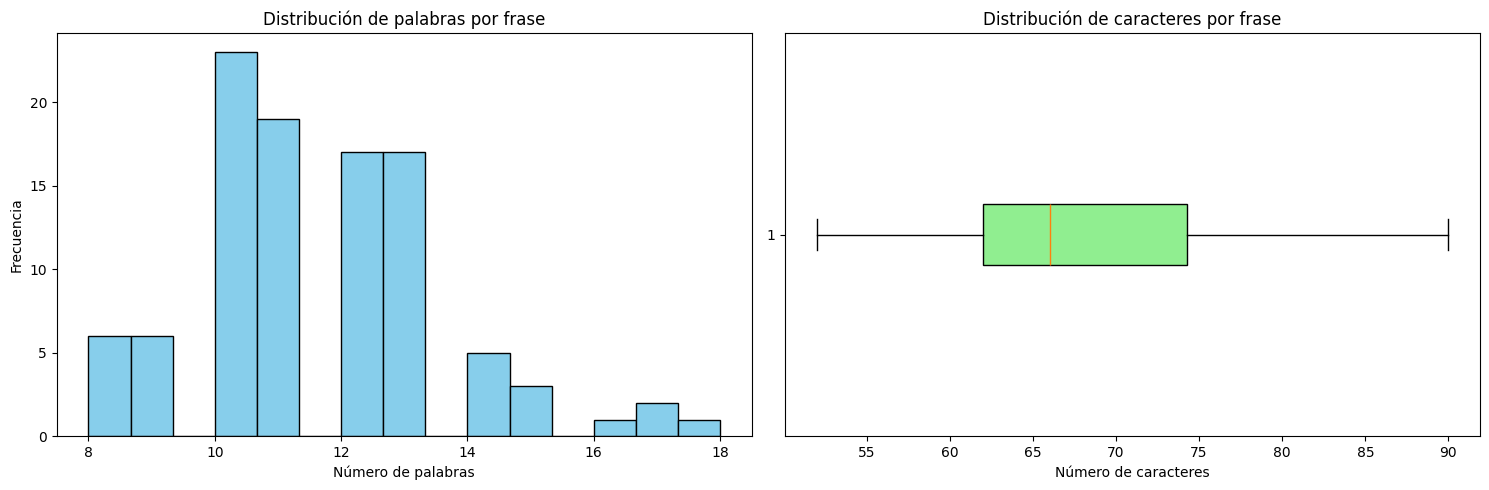

In [46]:
plt.figure(figsize=(15, 5))

# Histograma de palabras
plt.subplot(1, 2, 1)
plt.hist(lengths_words, bins=15, color='skyblue', edgecolor='black')
plt.title('Distribución de palabras por frase')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')

# Boxplot de caracteres
plt.subplot(1, 2, 2)
plt.boxplot(lengths_chars, vert=False, patch_artist=True, 
           boxprops=dict(facecolor='lightgreen'))
plt.title('Distribución de caracteres por frase')
plt.xlabel('Número de caracteres')

plt.tight_layout()
plt.show()

### Análisis de frecuencia de palabras

Más que por curiosidad, encontrar las palabras más repetidas (aparte de las conjunciones, interjecciones, preposiciones... que no dan especial valor) puede sernos útil, como veremos más tarde, para intuir "lineas de pensamiento" o tópicos/temáticas comunes en distintos subdominios del espacio vectorial del que se haya muestrado el dataset. Esto es, podemos hacer a la idea de las temáticas centrales de sus objetos (frase).

In [47]:
word_freq = Counter(" ".join(sentences).lower().split())
top_words = word_freq.most_common(30)

print("\nTop 30 palabras más frecuentes")
for i, (word, count) in enumerate(top_words, 1):
    print(f"{i}. {word}: {count} ocurrencias")


Top 30 palabras más frecuentes
1. the: 144 ocurrencias
2. a: 54 ocurrencias
3. was: 49 ocurrencias
4. of: 32 ocurrencias
5. it: 27 ocurrencias
6. in: 21 ocurrencias
7. to: 15 ocurrencias
8. and: 14 ocurrencias
9. its: 14 ocurrencias
10. with: 12 ocurrencias
11. that: 12 ocurrencias
12. so: 11 ocurrencias
13. had: 11 ocurrencias
14. for: 10 ocurrencias
15. making: 10 ocurrencias
16. an: 9 ocurrencias
17. could: 8 ocurrencias
18. were: 7 ocurrencias
19. into: 7 ocurrencias
20. like: 5 ocurrencias
21. but: 5 ocurrencias
22. seemed: 5 ocurrencias
23. small: 5 ocurrencias
24. as: 5 ocurrencias
25. on: 4 ocurrencias
26. plant: 4 ocurrencias
27. made: 4 ocurrencias
28. car: 4 ocurrencias
29. unique: 4 ocurrencias
30. required: 3 ocurrencias


Se ve que hemos de llegar nada menos que al puesto 25 para encontrar palabras frecuentes semánticamente informativas (plant, car...).

### Nube de palabras

Una nube de palabras es una herramienta muy útil para mapear frecuencia en relevancia visual (bruta). Aunque sería más útil que se mapeara en relevancia semántica; veremos sobre esto más adelante. <span style="color:green">Usamos la librería `wordcloud` para generar el gráfico:</span>

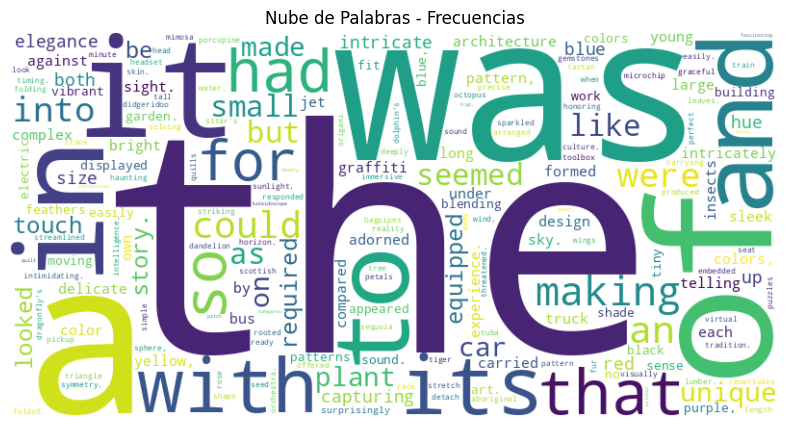

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras - Frecuencias")
plt.show()

Como veremos, hay maneras de arreglar el problema de palabras poco informativas en el dataset.

### Análisis de patrones sintácticos

Sería interesante poder sonsacar temáticas comunes entre los objetos (las frases), lo que puede darnos un indicio de "a qué está enfocado este dataset" (¿animales, instrumentos musicales, juegos de palabras, metáforas...?). <span style="color:red">Esto se denomina "análisis de patrones sintáctico".</span>

Aquí podemos preguntarnos si hay alguna librería que realice una representación visual de las relaciones sintácticas entre objetos y componentes de objetos. <span style="color:red">La librería `spaCy`, por ejemplo, nos ayuda a analizar el texto a nivel morfosintáctico, identificar dependencias gramaticales y visualizar estructuras de oración mediante su herramienta `displacy`. Y `pyLDAvis` permite visualizar de forma interactiva los temas generados por modelos LDA, facilitando la interpretación de tópicos en grandes corpus de texto. Por otro lado, `Gensim` ofrece una implementación eficiente de modelos de tópicos como LDA y Word2Vec, útil para extraer representaciones semánticas del texto, y `NLTK` proporciona herramientas básicas pero muy completas para procesamiento lingüístico, como tokenización, stemming, etiquetado POS y construcción de árboles sintácticos. Por otro lado, `scikit-learn` también permite construir modelos LDA o aplicar técnicas como TF-IDF y clustering para extraer y representar patrones temáticos en textos. 

<span style="color:green">Por ejemplo, se podría hacer uso de `spaCy` para analizar la estructura gramatical de las oraciones, identificar dependencias sintácticas y lematizar el texto (e.g. simplificar hasta la raiz de cada palabra), `sklearn` para construir un modelo de tópicos LDA (Latent Dirichlet Allocation), que permite descubrir automáticamente los temas principales en un conjunto de documentos y `pyLDAvis` para visualizar de forma interactiva los temas generados por un modelo LDA aplicado al cuerpo de texto.</span> Entraremos un poco en estos aspectos más adelante.

## Preprocesamiento 

Antes de continuar con un análisis complejo, algún paso previo puede ser la verificación de ausencia de datos nulos, relleno (e.g. interpolación, inpainting, *data completion*...) u <span style="color:red">otras técnicas de tratamiento/procesamiento textural interesantes, como pueden ser: eliminación de caracteres no alfabéticos, minimización de palabras "vacías" (filtrado de *stopwords*), normalización (stemming/lemmatización), detección de bigramas o trigramas más frecuentes, detección del idiomma, codificación, correlación de longitud (e.g.: ¿las frases con ciertas palabras son más largas?), etc.</span> Es probable que algunas de estas técnicas mejoren la calidad representativa de los vectores que representan las palabras de la base de datos (ver a continuación).

<span style="color:green">Por ejemplo, a continuación se realiza una lematización básica, eliminación de signos (caracteres no alfanuméricos) y de stopwords, con `spacy` (se debe instalar `en_core_web_sm` mediante `python -m spacy download en_core_web_sm`):</span>

In [49]:
!python -m spacy download en_core_web_sm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [50]:
import spacy

# Cargar modelo de lenguaje en español
nlp = spacy.load("en_core_web_sm")

# Preprocesamiento: lematización, eliminación de signos y stopwords
sentences_clean = []

for i, sent in enumerate(sentences[:]):
    doc = nlp(sent)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    clean_sent = " ".join(tokens) # Juntar los tokens separándolos por un espacio
    sentences_clean.append(clean_sent) 
    if (i in range(5)): # Solo mostrar las 5 primeras
        print(f"Original {i + 1}: {sent}")
        print(f"Limpia   {i + 1}: {clean_sent}\n")

Original 1: The dragonfly's wings sparkled like gemstones in the sunlight.
Limpia   1: dragonfly wing sparkle like gemstone sunlight

Original 2: The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.
Limpia   2: bagpipe adorn tartan pattern honor scottish tradition

Original 3: The fur pattern on the tiger was striking and intimidating.
Limpia   3: fur pattern tiger strike intimidating

Original 4: The triangle was simple but required precise timing.
Limpia   4: triangle simple require precise timing

Original 5: The sequoia tree was so tall it seemed to touch the sky.
Limpia   5: sequoia tree tall touch sky



Como curiosidad, así se vería la nube de palabras realizándola en los datos preprocesados (muy distinta [más informativa] a aquella presentada más arriba):

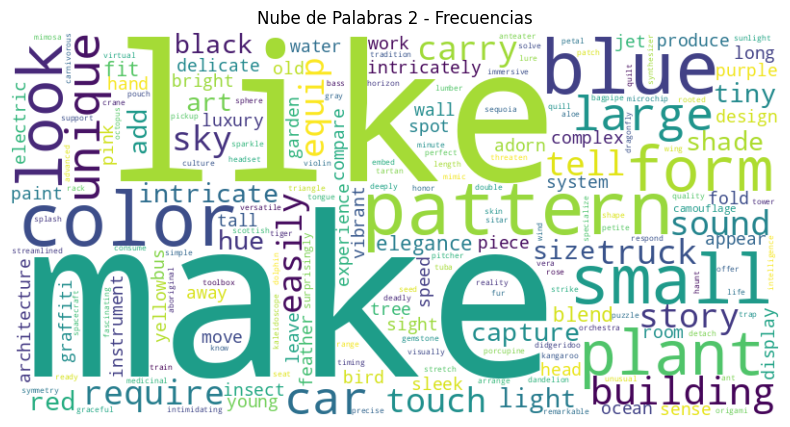

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
word_freq = Counter(" ".join(sentences_clean).lower().split())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de Palabras 2 - Frecuencias")
plt.show()

Para el resto del notebook se continuará usando el dataset original sacado directamente de la carga de `sentences.json`, aunque parece razonable que en un escenario real se siga preprocesando el dataset acordemente y se emplee el dataset tratado, en vez del original, según los requisitos específicos de la aplicación.

## Análisis semántico

Una de las capacidades más aclamadas de los modelos de lenguaje es su capacidad de transformar lenguaje simbólico en lenguaje matemático, es decir, de funcionamiento como transformador de sistemas formales de representación de información. Es difícil establecer métricas de cercanía analíticas entre dos palabras (e.g. "coche" y "rueda"), aunque abstractamente nos resulte altamente lógico asociarlas, gracias a nuestra experiencia visual y memoria, principalmente. Sin embargo, los modelos de lenguaje son indicadas para convertir palabras en vectores numéricos (*embeddings*), estrechamente relacionados (¿biunívocamente?, cabría investigar si el proceso suele ser determinista) con las palabras originales. Y definir métricas, distancias, normas, cercanía... entre vectores numéricos es un problema ampliamente resuelto.

Además, los embeddings se forman sobre un espacio continuo (de números reales) de baja dimensión, lo cual es similar a la reducción de dimensionalidad comentada en el apartado de compresión con pérdida. Sin embargo, intuitivamente, los embeddings, al ser representaciones densas, podrían parecen no perder tanta información. Concretamente, si asumimos como "dimensionalidad" a la cantidad de features numéricas (componentes) utilizadas para representar vectorialmente una frase, se dice que el embedding es de baja dimensionalidad porque tiene muchas menos dimensiones que los datos (e.g. textos) si ueran codificados con técnicas tipo one-hot-encoding [9]. La idea más importante es que frases similares tendrán vectores cercanos en el espacio de embeddings.

Así pues, una tarea típica es analizar patrones y estructuras en el espacio de embeddings, en vez de en el espacio de las palabras. Modelos que nos pueden ayudar a hacer esto son Word2Vec (que es más bien una familia de arquitecturas y optimizaciones, de las primeras capaces de <span style="color:green">"resumir numéricamente el significado semántico"</span>) [4], BERT (genera embeddings a nivel de palabra o frase con atención al contexto) [5], S-BERT (extensión de BERT para comparar frases o textos cortos con embeddings de alta calidad) [5], modelos de OpenAI [6],etc.

Usaremos un modelo de tipo **Sentence Transformer** o S-BERT (Sentence-BERT) [7] para convertir las frases en vectores de alta dimensión (densos) que tratarán de capturar su significado intrínseco. La librería `sentence-transformers` es la herramienta principal para esta tarea, pues facilita enormemente la generación de embeddings semánticos. Usaremos el modelo `all-MiniLM-L6-v2`, que es una implementación ligera de tipo S-BERT, la cual que mapea frases y párrafos en un espacio vectorial denso de 384 dimensiones. Los embedding generados podrán ser luego usados para tareas tan interesantes como el clustering o la búsqueda semántica [10]. 

A continuación el script que genera un embeddings de cada frase dada en el dataset proporcionado.

In [52]:
from sentence_transformers import SentenceTransformer

with open('sentences.json') as f:
    sentences = json.load(f)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences, show_progress_bar=True)
print(f"El dataset tienee {len(sentences)} frases. Se computaron {embeddings.shape[0]} embeddings de dimensión {embeddings.shape[1]}.")

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

El dataset tienee 100 frases. Se computaron 100 embeddings de dimensión 384.


## Reducción de dimensionalidad

Como se comentó antes, podemos hacer uso de algoritmos de t-SNE (t-Distributed Stochastic Neighbor Embedding) destinados a reducir la dimensionalidad de los datos e incluso proporcionar representaciones gráficas/visuales mediante proyecciones 2D/3D que permitan vislumbrar información y relaciones/características semánticas valiosas, <span style="color:green">manteniendo hasta cierto punto la estructura local del espacio de alta dimensión original. </span><span style="color:red">También se realiza una visualización de los datos mostrando solo algunas de las frases, por temas de espacio.</span>

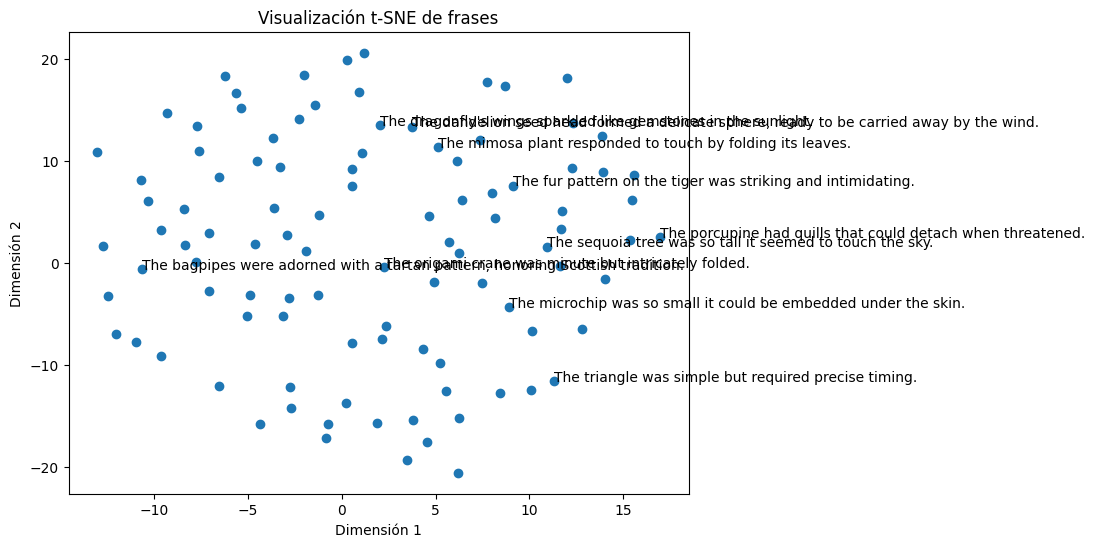

In [53]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# n_componentes indica a cuántas dimensiones se quieren reducir los datos 
# random_state fija una semilla para tener resultados reproducibles
# perplexity controla cuántos vecinos más cercanos considera para preservar la estructura en la medida de los posible al proyectar
tsne = TSNE(n_components=2, perplexity=15, random_state=15) 
embeddings_2d_tsne = tsne.fit_transform(embeddings)
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]) 
for i, frase in enumerate(sentences[:10]):
    plt.annotate(frase, (embeddings_2d_tsne[i, 0], embeddings_2d_tsne[i, 1]))
plt.title("Visualización t-SNE de frases")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.show()

Podemos ver que t-SNE logra agrupar frases **semánticamente** similares (i.e. los embeddings no "miran" solo la longitud, número de palabras... sino su verdadero significado interno). A muy alto nivel, parece que la dimensión 1 aumenta con la naturaleza (de figuras geométricas, artefactos y componentes electrónicos a plantas y animales) y la dimensión 2 aumenta con la complejidad de la descripción, los atributos físicos del sustantivo o la relación entre elementos (por decir algo). 

También se puede proyectar hacia un <span style="color:red">sistema de 3 componentes</span> (las interpretaciones podrían cambiar con respecto a la representación anterior):

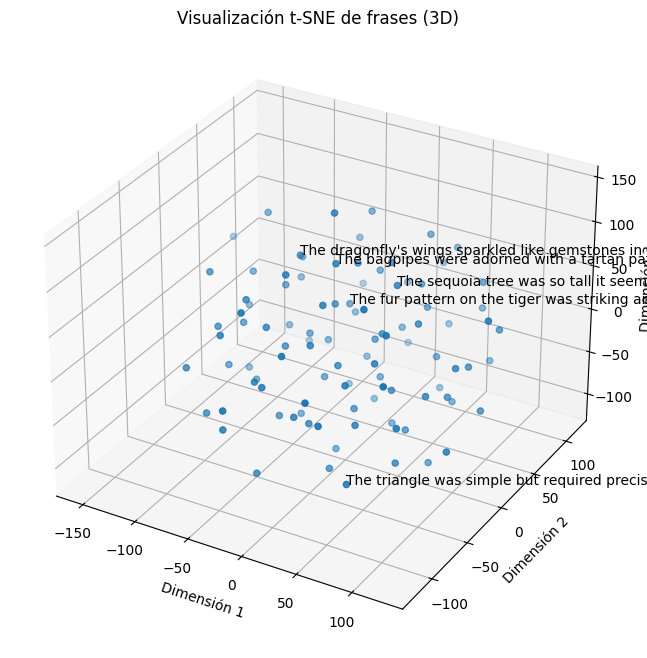

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=3, perplexity=15, random_state=15)
embeddings_3d_tsne = tsne.fit_transform(embeddings)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') 
ax.scatter(embeddings_3d_tsne[:, 0], embeddings_3d_tsne[:, 1], embeddings_3d_tsne[:, 2])
for i, frase in enumerate(sentences[:5]):
    ax.text(embeddings_3d_tsne[i, 0], embeddings_3d_tsne[i, 1], embeddings_3d_tsne[i, 2], frase)
ax.set_title("Visualización t-SNE de frases (3D)")
ax.set_xlabel("Dimensión 1")
ax.set_ylabel("Dimensión 2")
ax.set_zlabel("Dimensión 3")
plt.show()

## *Clustering*

<span style="color:green">Tras analizar semánticamente el dataset, una aplicación típica y que podemos llevar a cabo con este dataset es un clustering</span>, i.e. un agrupamiento por "conceptos clave" (clusters) acerca de los que "tratan" las frases del dataset. ¿Hablan sobre grupos de animales, grupos de instrumentos musicales, sobre descripciones de sustantivos y adjetivos, emociones, acciones, lugares...? <span style="color:red">Y cómo se relacionan semánticamente entre sí: ¿hay frases que se refieran a contextos similares aunque usen palabras distintas?, ¿existen transiciones suaves entre grupos temáticos?.</span>

Este tipo de cuestiones se pueden resolver de manera no supervisada gracias a algoritmos de clustering, como k-means, que usaremos aquí (por razones ejemplificativas, pues es uno de los más básicos), DBSCAN, HDBSCAN, etc. Los embeddings generados mediante S-BERT en el paso anterior nos habilitan para poder computar distancias en un espacio semántico, donde la proximidad refleja similitud conceptual. A partir de esta representación, los algoritmos de clustering pueden identificar agrupaciones naturales sin necesidad de etiquetas predefinidas, permitiéndonos descubrir patrones y temas latentes en el dataset.

El proceso de clusterización se resume así:

1. Primero hay que determinar el número de clusters en los que queremos agrupar los datos. Es recomendable que esta selección sea formada, automáticamente fundamentada en un criterio técnico, y no estimada subjetivamente. Una manera típica de seleccionar el número óptimo de clusters es <span style="color:red">analizando la suma de cuadrados intra-cluster (WCSS). </span>. Queremos usar k-means para clusterizar, así que antes de nada ejecutamos k-means (u otro algoritmo, realmente) con tantos clusters como queramos valorar para la selección del número óptimo (e.g. de 1 a 10 clusters). 

2. k-means agrupa los datos asignando a cada uno el cluster más cercano en términos de distancia euclídea (L2) y luego recalcula los centroides como el promedio de los puntos en cada grupo, repitiendo este proceso hasta que los centroides dejan de moverse significativamente. <span style="color:red"> Así, encuentra particiones que minimizan la variación interna dentro de cada cluster. </span>

3. WCSS consiste en calcular la suma de las distancias al cuadrado entre cada punto y el centroide del cluster al que está asignado. Luego, se repite este proceso para todos los puntos del grupo, se suman los valores del grupo y se dividen entre el número de puntos para normalizar la escala [11]. Luego se aplica el criterio del codo para seleccionar el número óptimo de clusters, <span style="color:green">que analiza cómo disminuye WCSS al aumentar al número de clusters: más allá de ese punto, agregar más clusters no mejora significativamente la compactación de los grupos.</span>

4. Nos quedamos con el resultado de k-means con el número de clústers óptimo, que ya estaría computado el primer paso.

<span style="color:green">A continuación se muestra un script sencillo que usa k-means para agrupar los embeddings proyectados en 2D resultado del t-SNE aplicado en el paso anterior (no se grafican por motivos de espacio, pero se muestrean algunas frases de cada clusters después de visualizarlos):</span>

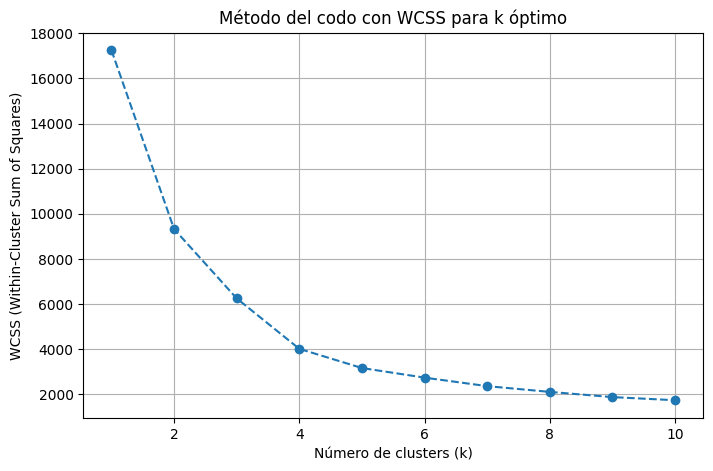

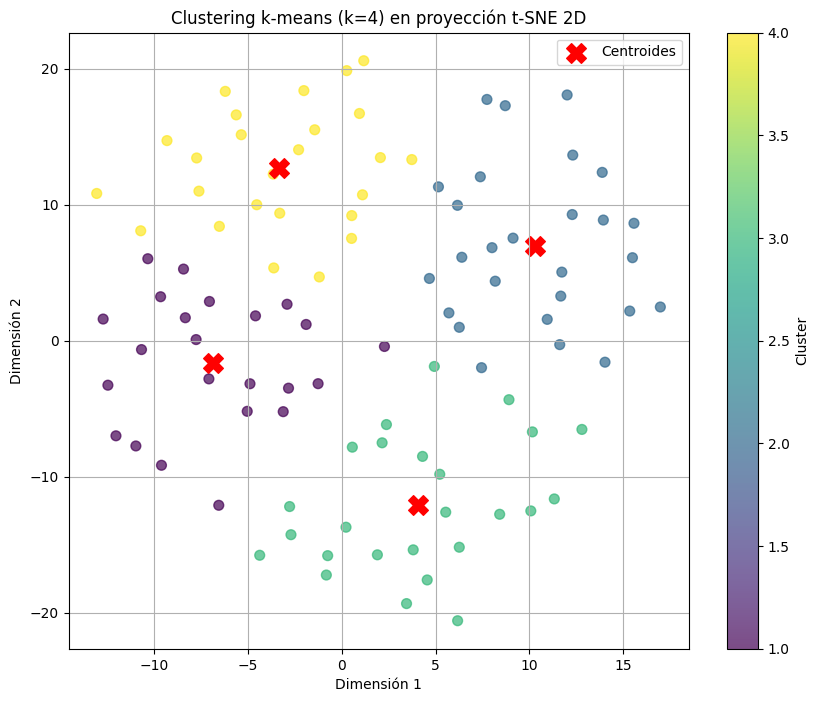


Cluster 1:
- The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.
- The origami crane was minute but intricately folded.
- The didgeridoo produced a haunting sound that was deeply rooted in Aboriginal culture.
- The pickup truck had a toolbox and a rack for carrying lumber.
- The tuba was so large it required its own seat in the orchestra.

Cluster 2:
- The fur pattern on the tiger was striking and intimidating.
- The sequoia tree was so tall it seemed to touch the sky.
- The mimosa plant responded to touch by folding its leaves.
- The porcupine had quills that could detach when threatened.
- The dolphin's streamlined shape made it look graceful in water.

Cluster 3:
- The triangle was simple but required precise timing.
- The microchip was so small it could be embedded under the skin.
- The virtual reality headset offered an immersive experience.
- The length of the train seemed to stretch into the horizon.
- The sitar's complex architecture made it visually 

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Método del codo a gráfica de WCSS para encontrar el número óptimo de clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(embeddings_2d_tsne)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Método del codo con WCSS para k óptimo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# Seleccionar K y entrenar k-mean
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(embeddings_2d_tsne) + 1

# Visualizar clusters y centroides
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1],
                      c=clusters, cmap='viridis', alpha=0.7, s=50)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], 
            marker='X', s=200, c='red', label='Centroides')
plt.colorbar(scatter, label='Cluster')
plt.title(f'Clustering k-means (k={k}) en proyección t-SNE 2D')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar frases por cluster
for cluster_id in range(1, k + 1):
    print(f"\nCluster {cluster_id}:")
    cluster_indices = np.where(clusters == cluster_id)[0]
    for idx in cluster_indices[:5]: # Mostrar 5 frases por cluster
        print(f"- {sentences[idx]}")

Se podrían seleccionar 4 clusters como **k** óptimo (podrían ser 5 también; podríamos usar un criterio de disminución porcentual del valor relativo de WCSS [e.g. cuándo comienza a bajar más de un 90 % del total del rango dinámico]), viendo la gráfica del WCSS, según el criterio del codo. Los resultados de agrupamiento parecen razonables, se ve que el método tiende (en el sentido de Fisher) a maximizar la varianza inter-clase mientras minimiza la varianza intra-clase, esto es, manteien los centroides de los clústers alejados mientras los puntos de cada clúster están cerca de sus respectivos centroides (lo máximo posible).

> Nota
>
> También podrían agruparse las proyecciones 3D, o incluso los datos originales antes de ser reducidos en dimensión. Sería interesante investigar en qué situaciones es preferible o no hacer clustering a unos u otros (por motivos de pérdida de información, finalidad real del clustering, etc.).

Con un vistazo rápido a los clusters, se ve que el primero se enfoca en temas culturales y música, el segundo en características de la naturaleza, el tercero en estructura geométrica y el cuarto en artefactos humanos. <span style="color:red">Otro análisis rápido sobre los centroides de los clusters nos lo puede dar una LLM como DeepSeek:</span>

<span style="color:red">- Cluster 1: Cultura + precisión técnica (instrumentos musicales, microchips, arte en diseño).</span>

<span style="color:red">- Cluster 2: Naturaleza adaptativa (plantas, animales, inteligencia biológica).</span>

<span style="color:red">- Cluster 3: Escala + diseño industrial (grandes estructuras, vehículos, formas aerodinámicas).</span>

<span style="color:red">- Cluster 4: Arte + utilidad (artesanía, color, tecnología aplicada).</span>


## Búsqueda semántica

Imaginémonos que ya tenemos nuestro dataset de frases y queremos buscar todas aquellas frases que traten, digamos, de animales de la naturaleza.  
El método de fuerza bruta nos obligaría a buscar, una a una, aquellas frases que contuvieran (buscando palabra por palabra), un objeto dentro del grupo semántico de interés.  
Pero una búsqueda semántica mediante modelos Sentence Transformers, como el `all-MiniLM-L6-v2` antes visto, nos ayuda a hacer la búsqueda mucho más eficiente en el espacio de los embeddings, pues allí la proximidad entre vectores se traduce en proximidad semántica en nuestro lenguaje natural.

Así pues, <span style="color:green">en el siguiente script</span> el usuario puede escribir en el textbox un prompt (modificar variable `query`) con una palabra (todo lo concreta o genérica que se quiera), y el modelo buscará en el dataset todas las frases (íntimamente) relacionadas con la palabra objetivo (target) y, finalmente, se imprimirán. Se usa una de las métricas de proximidad más comunes, la distancia del coseno, que devuelve valores entre -1 (opuestos en significado) y 1 (idénticos en significado) (vale 0 si son ortogonales) (si los vectores están normalizados es equivalente al producto escalar usual); de esta forma, podría definirse un umbral por encima del cual se considera que el prompt es similar a la frase con la que se compara, y por debajo del cual no lo es.

In [56]:
# Precomputar embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm  

model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = []
for sentence in tqdm(sentences, desc="Codificando frases"):
    embedding = model.encode(sentence)
    sentence_embeddings.append(embedding)
sentence_embeddings = np.array(sentence_embeddings)

Codificando frases:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Testear
query = "prompt ocurrente" # Prompt del usuario
query_embedding = model.encode([query])

similarities = []
for emb in tqdm(sentence_embeddings, desc="Calculando similitudes"):
    sim = cosine_similarity(query_embedding.reshape(1, -1), emb.reshape(1, -1))[0][0] # reshape() para formar matrices (1, n) con los vectores 1D
    similarities.append(sim)
similarities = np.array(similarities)

top_n = 5
indices = similarities.argsort()[::-1][:top_n]
print(f"\nFrases más relacionadas con: '{query}'\n")
for idx in indices:
    print(f"- {sentences[idx]}  (similitud: {similarities[idx]:.2f})")

Calculando similitudes:   0%|          | 0/100 [00:00<?, ?it/s]


Frases más relacionadas con: 'prueba técnica'

- The aloe vera plant was known for its medicinal qualities.  (similitud: 0.19)
- The mimosa plant responded to touch by folding its leaves.  (similitud: 0.16)
- The intricate veins of the fern leaf formed a natural work of art.  (similitud: 0.16)
- The coffee plant was cherished for the beans it produced.  (similitud: 0.14)
- The sitar's complex architecture made it visually fascinating.  (similitud: 0.13)


Resultados para "tecnología moderna":

```txt
- The intricate veins of the fern leaf formed a natural work of art.  (similitud: 0.32)
- The quilt was a kaleidoscope of colors, each patch telling its own story.  (similitud: 0.25)
- The accordion was decorated with ornate patterns that gave it an old-world charm.  (similitud: 0.24)
- The canoe was crafted from a single tree, showcasing traditional craftsmanship.  (similitud: 0.24)
- The didgeridoo produced a haunting sound that was deeply rooted in Aboriginal culture.  (similitud: 0.23)
```

Resultados para "fauna salvaje":

```txt
- The Venus flytrap was small but fierce, capturing insects with precision.  (similitud: 0.34)
- The carnivorous pitcher plant lured insects into its deadly trap.  (similitud: 0.30)
- The anteater had a long tongue specialized for consuming ants.  (similitud: 0.26)
- The dolphin's streamlined shape made it look graceful in water.  (similitud: 0.25)
- Compared to the cargo ships, the jet ski appeared as tiny as a minnow in a pond.  (similitud: 0.25)
```

### Resumen de texto

Como aplicación interesante, podemos ver qué pasa si tratamos de resumir un texto más o menos extenso. Al igual que cuando comprimimos una imagen el resultado parece una versión "suavizada" de la imagen, donde intuimos las formas, objetos, la escena... pero los detalles finos como bordes y esquinas se pierden, intuitivamente un texto comprimido podría ser un resumen del original, que captura las ideas esenciales pero perdiendo detalles de menor relevancia general. Es importante distinguir entre compresión cruda (embeber el mensaje intrínseco completo en un archivo de menor peso) y compresión semántica (eliminar lo menos importante del mensaje intrínseco). Para realizar una compresión semántica útil, un paso previo sería deshacerse de todas las interjecciones, preposiciones, signos de puntuación... redundantes y que no añadan valor a las sentencias (i.e. lematización, como se vio anteriormente), quizá, pues si no la frecuencia de palabras sin significado propio puede menoscabar el resultado de la compresión. Pero en este ejemplo pincelaremos una solución inicial con las funciones antes presentadas.

El texto a resumir es de este tipo (text.txt):
```
[...]

A continuación se esquematiza el flujo general del problema que se pretende resolver y, marcadas en verde, las partes trabajadas hasta el momento. Más adelante se trazará una lista de objetivos completados.

Objetivos generales:

O1 - Diseñar filtros adaptativos eficientes y generalizables a diversas geometrías, densidades y tipos de ruido.
O2 - Preservar detalles geométricos (bordes, esquinas) en presencia de ruido real no Gaussiano

[...]
```

A continuación <span style="color:red"> se muestra el script</span> que lo lleva a cabo. <span style="color:green">Leeremos el texto completo de archivo, lo dividiremos en segmentos usando símbolos de puntuación como delimitadores de sentencias (elección arbitraria), aplicamos vectorización TF-IDF y descomposición SVD a la matriz término-segmento compuesta (que representa la importancia de cada palabra en cada segmento), elegimos los más relevantes seleccionando los valores propios principales (más grandes) como resumen y reconstruimos el texto, imprimiéndolo por pantalla. Finalmente, con estos componentes principales se reconstruye una versión simplificada del texto que sirve como resumen global, a través de la muestra de las palabras clave más importantes por segmento.</span> 

Dividimos el texto en segmentos porque realmente no es posible aplicar directamente SVD al texto completo, pues SVD necesita una matriz con múltiples filas y columnas para descomponerla en componentes significativos y, si se toma todo el texto como un solo bloque, la matriz TF-IDF resultante tendría solo una fila, ya que solo se tiene un “documento”.  

In [15]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import spacy

nlp = spacy.load("es_core_news_sm")

def split_text_into_sentences(text):
    sentences = re.split(r'(?<=[.!?])\s+', text.strip())
    return [s.strip() for s in sentences if len(s.strip()) > 0]

def lemmatize_sentences(sentences):
    sentences_clean = []
    for sent in sentences:
        doc = nlp(sent)
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
        clean_sent = " ".join(tokens)
        sentences_clean.append(clean_sent)
    return sentences_clean

def svd_reconstruct_text(text, k=5, top_words=5):
    sentences = split_text_into_sentences(text)
    clean_sentences = lemmatize_sentences(sentences)

    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(clean_sentences).toarray()

    U, s, Vt = np.linalg.svd(tfidf, full_matrices=False)

    Uk = U[:, :k]
    sk = np.diag(s[:k])
    Vtk = Vt[:k, :]

    tfidf_approx = Uk @ sk @ Vtk

    vocabulary = vectorizer.get_feature_names_out()
    reconstructed_sentences = []

    for row in tfidf_approx:
        top_indices = np.argsort(row)[-top_words:][::-1]
        words = [vocabulary[i] for i in top_indices if row[i] > 0]
        reconstructed_sentences.append(" ".join(words))

    return reconstructed_sentences

def remove_duplicates_preserve_order(words):
    seen = set()
    unique_words = []
    for w in words:
        if w not in seen:
            unique_words.append(w)
            seen.add(w)
    return unique_words

def process_text_svd_reconstruction(input_path='texto.txt', output_path='text_resumed.txt', k=5, top_words=3):
    with open(input_path, 'r', encoding='utf-8') as f:
        text = f.read()

    reconstructed = svd_reconstruct_text(text, k=k, top_words=top_words)

    # Unir todas las frases reconstruidas en una lista de palabras
    all_words = " ".join(reconstructed).split()

    # Eliminar palabras repetidas manteniendo el orden
    unique_words = remove_duplicates_preserve_order(all_words)

    reconstructed_text = " ".join(unique_words)

    print("Resumen del texto: \n")
    print(reconstructed_text)

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(reconstructed_text)

process_text_svd_reconstruction('texto.txt', 'text_resumed.txt', k=5, top_words=5)

Resumen del texto: 

ruido clave tesis crítico aplicación detalle geométrico método filtro dato grafo análisis problema algoritmo trabajo plan preservar real implementación sintético artículo denoising dependencia limitación resultado supervisado actual gaussiano reducir modelo evaluar desarrollo cuantitativo métrica redacción preservación basado revisión presencia nube


Un ejemplo de salida se lee a continuación:
```txt
ruido clave tesis crítico aplicación detalle geométrico método filtro dato grafo análisis problema algoritmo trabajo plan preservar real implementación sintético artículo denoising dependencia limitación resultado supervisado actual gaussiano reducir modelo evaluar desarrollo cuantitativo métrica redacción preservación basado revisión presencia nube
```

Como se ve, captura la esencia del texto a través de palabras claves, más que mediante una narrativa. Este método mantiene solo los componentes más relevantes y reconstruye una versión aproximada con las palabras clave del texto. Sin embargo, no puede reproducir el texto original ni crear un resumen narrativo coherente porque la matriz TF-IDF no guarda el orden ni la estructura completa del texto y la reducción elimina detalles importantes, por lo que solo ofrece una representación simplificada basada en la importancia estadística o frecuentista de los términos.

Por supuesto, un resumen semántico más avanzado se podría realizar con embeddings y autoencoders, por ejemplo, para lo primero habría que transformar el texto en embeddings, que capturan el significado de las palabras usando modelos preentrenados como BERT (como vemos en otras secciones del cuaderno). Luego, alimentar a un autoencoder con estos vectores, que consiste en una red neuronal que aprende a comprimir la información importante en una representación de más baja dimensión (encoder) y, finalmente, puede reconstruir el texto original (decoder). La parte comprimida generada por el encoder funciona como un resumen semántico que retiene la esencia del texto y, a partir de ella, se puede generar un resumen más corto y relevante.

# Conclusiones

A lo largo de este cuaderno se han aplicado y discutido sobre diversas técnicas para analizar y extraer patrones, características y, en general, información sobre un dataset de frases en inglés. Entre las acciones tomadas están:

- Compresión de datos: Se implementó una versión básica de RLE que, aunque resulta poco efectiva para el texto natural, evidencia la utilidad de métodos similares pero más sofisticados para la implementación eficiente de este tipo de soluciones.
- Reducción de la dimensionalidad: Se aplicó SVD a matrices de características TF-IDF, demostrando cómo se puede capturar la esencia semántica de las frases empleando pocos componentes principales (e.g. 5 frente a 100).
- Análisis exploratorio: Se inicia un EDA que revela patrones estadísticos y frecuentistas como la longitud media por caracteres y palabras de las frases, estadísticos críticos y distribución discreta de las palabras.
- Análisis semántico: Se usa un modelo Sentence Transformer que construye embeddings semánticos (concretamente vectores 384D) a partir de las frases, que capturan significado intrínseco. Con estos embeddings se realizan varias tareas de suma importancia: reducción de la dimensionalidad (de nuevo, pero en el espacio latente, no en el de los datos originales) y visualización de datos con t-SNE (agrupación semántica intuitiva), clustering (agrupamiento) con k-means (se identificaron 4 o 5 clústers temáticos identificados) y búsqueda semántica con la similitud dle coseno (comparación de prompt con frases más similares).

Todo esto tiene numerosas aplicaciones prácticas, que van desde los sistemas de recomendación (e.g. sugerir productos similares a los últimos comprados, en Retail), <span style="color:red">organización automática de contenido (e.g. organizar artículos científicos por temática usando sus *abstracts*), preprocesamiento para optimizar otros modelos de lenguaje (filtrado automático de frases atípicas [outliers en espacio embedding, balanceado de datasets basándose en distribución semántica...])</span>, etc.

Merece la pena seguir investigando muchos aspectos comentados como ideas o cuestiones abiertas a lo largo del cuaderno. Un tópico de suma relevancia es la mezcla de lenguaje natural con modelos de procesamiento de imagen o visión por computador 2D/3D; algo que ya comenzó a hacerse con los ViT usando "parches" de las imágenes en vez de "frases", lo que permitió que estos modelos superaran, en cierto sentido, a las redes neuronales convolucionales otrora dominantes (superándolas sobre todo en el contexto global y en las relaciones entre elementos inconexos espacialmente en el dominio de la imagen). El ensamblado de modelos mixtos como MaskCLIP (Mask Contrastive Language–Image Pre-training) [12] o LERF (Language Embeddings Radiance Fields) [13] es un próximo paso de mucha importancia, también.

## Referencias

[1] https://github.com/maxi-w/CLIP-SAM

[2] https://github.com/isl-org/lang-seg?tab=readme-ov-file

[3] https://www-ee.eng.hawaii.edu/~tep/EE160/Book/chap4/subsection2.1.1.1.html

[4] https://www.tensorflow.org/text/tutorials/word2vec

[5] https://medium.com/@chetanchhabra1401/bert-v-s-s-bert-a9984ee2093d

[6] https://platform.openai.com/docs/guides/embeddings

[7] https://sbert.net/#sentencetransformers-documentation

[8] https://www.geeksforgeeks.org/how-to-store-a-tfidfvectorizer-for-future-use-in-scikit-learn/

[9] https://developers.google.com/machine-learning/crash-course/embeddings/embedding-space?hl=es-419

[10] https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

[11] https://www.mql5.com/es/articles/11615

[12] https://maskclip.github.io/

[13] https://www.lerf.io/